In [1]:
import tables as tb
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

from labelling.MClabelling           import labelling_MC
from labelling.beershebalabelling    import labelling_beersheba
from utils.beersheba_labelling_utils import label_neighbours_ordered
from utils.data_utils                import get_event_id 
from utils.histogram_utils           import container_creator, bin_creator

import invisible_cities.io.dst_io as dio

from utils.plotting_utils import plot_cloud_voxels, plot_cloud_voxels_and_hits, plot_3d_hits

# Función final
Junto todo en una función y pruebo el resultado

In [3]:
cutnum, num = '24', '6206'
directory   = '/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut{cut}.beersheba_{num}.root.h5'.format(cut = cutnum, num = num)

total_size  = (440, 440, 550) 
voxel_size  = (5, 5, 2) #equivalent to step
start_bin   = (-220, -220, 0) #equivalent to x0

In [4]:
detector_container = container_creator(total_size, voxel_size)
detector_bins = bin_creator(detector_container, steps = voxel_size, x0 = start_bin)

In [5]:
def label_file(directory, 
               total_size, 
               voxel_size, 
               start_bin, 
               label_neighbours_function,
               blob_ener_losss_th = None, 
               blob_ener_th = None, 
               simple = True, 
               relabel = True,
               binclass = True,
               segclass = True):
    '''
    Function that performs the whole beersheba labelling. Starting from the MC hits, they are labelled in three
    classes (rest, track, blob) and voxelized with the labelling_MC function. Then, with the labelling_beersheba
    we voxelize the reconstructed hits. These voxels are merged with the MC voxels in order to match information.
    Some corrections are done to those MC voxels that fall outside the beersheba voxels. Once that is done, the
    algorithm labels the empty beersheba voxels as neighbours of one of the main classes. It is also created a new
    ghost class to label those disconnected voxels that arise from the beersheba reconstruction that don't have
    a MC origin, so they don't have main class neighbours to be labelled.
    
    Args: 
        directory: STR
    Contains the directory of a file with several events with Monte Carlo and beersheba hits information.
    
        total_size: TUPLE 
    Contains the max size of the detector.
    
        voxel_size: TUPLE
    Contains the voxel size of the detector for each coordinate.
    
        start_bin: TUPLE
    Contains the first voxel position for each coordinate.
    
        label_neighbours_function: FUNCTION
    Selected function to perform the neighbour labelling (so I can easily change the method)
    
        blob_ener_loss_th: FLOAT
    Energy loss percentage of total track energy for the last hits that establishes a threshold for the blob class.
        
        blob_ener_th: FLOAT
    Energy threshold for the last hits of a track to become blob class.
        
        simple: BOOL
    If True, in the voxelization we will only use hits energy information. Else, the voxelization would include 
    the information of some feature (with its ratio), which in beersheba data it's just the npeak variable. I 
    don't really know if this is an important information.
    
        relabel: BOOL
    If True, the merge_MC_beersh_voxels would try to include the external MC labelled voxels to some empty beersheba
    voxels, so we can benefit from this information. Else, this info will be lost and we would stick only to the 
    true coincident voxels.
    
        binclass: BOOL
    If True, labelling_MC function will be passed. Otherwise, it will return empty dataframes.
    
        segclass: BOOL
    If True, and if binclass is also True (because we need MC labelled voxels information), labelling_beersheba
    will be passed. Otherwise, if False or if binclass False, will return an empty dataframe.
    
    RETURNS:
        labelled_MC_voxels: DATAFRAME
    If the conditions are satisfied (binclass = True), this contains the labelled MC voxels for each event in 
    the file.
        
        labelled_MC_hits: DATAFRAME
    If the conditions are satisfied (binclass = True), this contains the labelled MC hits for each event in the
    file. We will use them to plot nicer images.
        
        labelled_beersheba: DATAFRAME
    If the conditions are satisfied (binclass and segclas = True), this contains the labelled beersheba voxels
    for each event in the file.
    '''
    
    #Just in case binclass and segclass are False, to return something
    labelled_MC_voxels, labelled_MC_hits, labelled_beersheba = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    if binclass:
        labelled_MC_voxels, labelled_MC_hits = labelling_MC(directory, 
                                                            total_size, 
                                                            voxel_size, 
                                                            start_bin, 
                                                            blob_ener_loss_th = blob_ener_losss_th, 
                                                            blob_ener_th = blob_ener_th)
    
    if binclass and segclass:
        labelled_beersheba = labelling_beersheba(directory, 
                                                 total_size, 
                                                 voxel_size, 
                                                 start_bin, 
                                                 labelled_MC_voxels, 
                                                 label_neighbours_function, 
                                                 simple = simple, 
                                                 relabel = relabel)
    
        #Rename to match the names in the next_sparseconvnet functions
        labelled_beersheba = labelled_beersheba.rename(columns={'x': 'xbin', 
                                                                'y': 'ybin', 
                                                                'z': 'zbin', 
                                                                'beersh_ener': 'energy', 
                                                                'ener': 'MC_ener'})
    else:
        print('No labelling has been performed')
        
    return labelled_MC_voxels, labelled_MC_hits, labelled_beersheba

In [6]:
labelled_MC_voxels, labelled_MC_hits, labelled_beersheba = label_file(directory, 
                                                                      total_size, 
                                                                      voxel_size, 
                                                                      start_bin, 
                                                                      label_neighbours_ordered, 
                                                                      blob_ener_losss_th = 0.25, 
                                                                      binclass = True, 
                                                                      segclass = True)

In [7]:
nevent = 34

In [8]:
event_id = get_event_id(cutnum, nevent)

In [9]:
event_beersh = labelled_beersheba[labelled_beersheba.event_id == event_id]

In [10]:
event_hits = labelled_MC_hits[labelled_MC_hits.event_id == event_id]

<IPython.core.display.Javascript object>


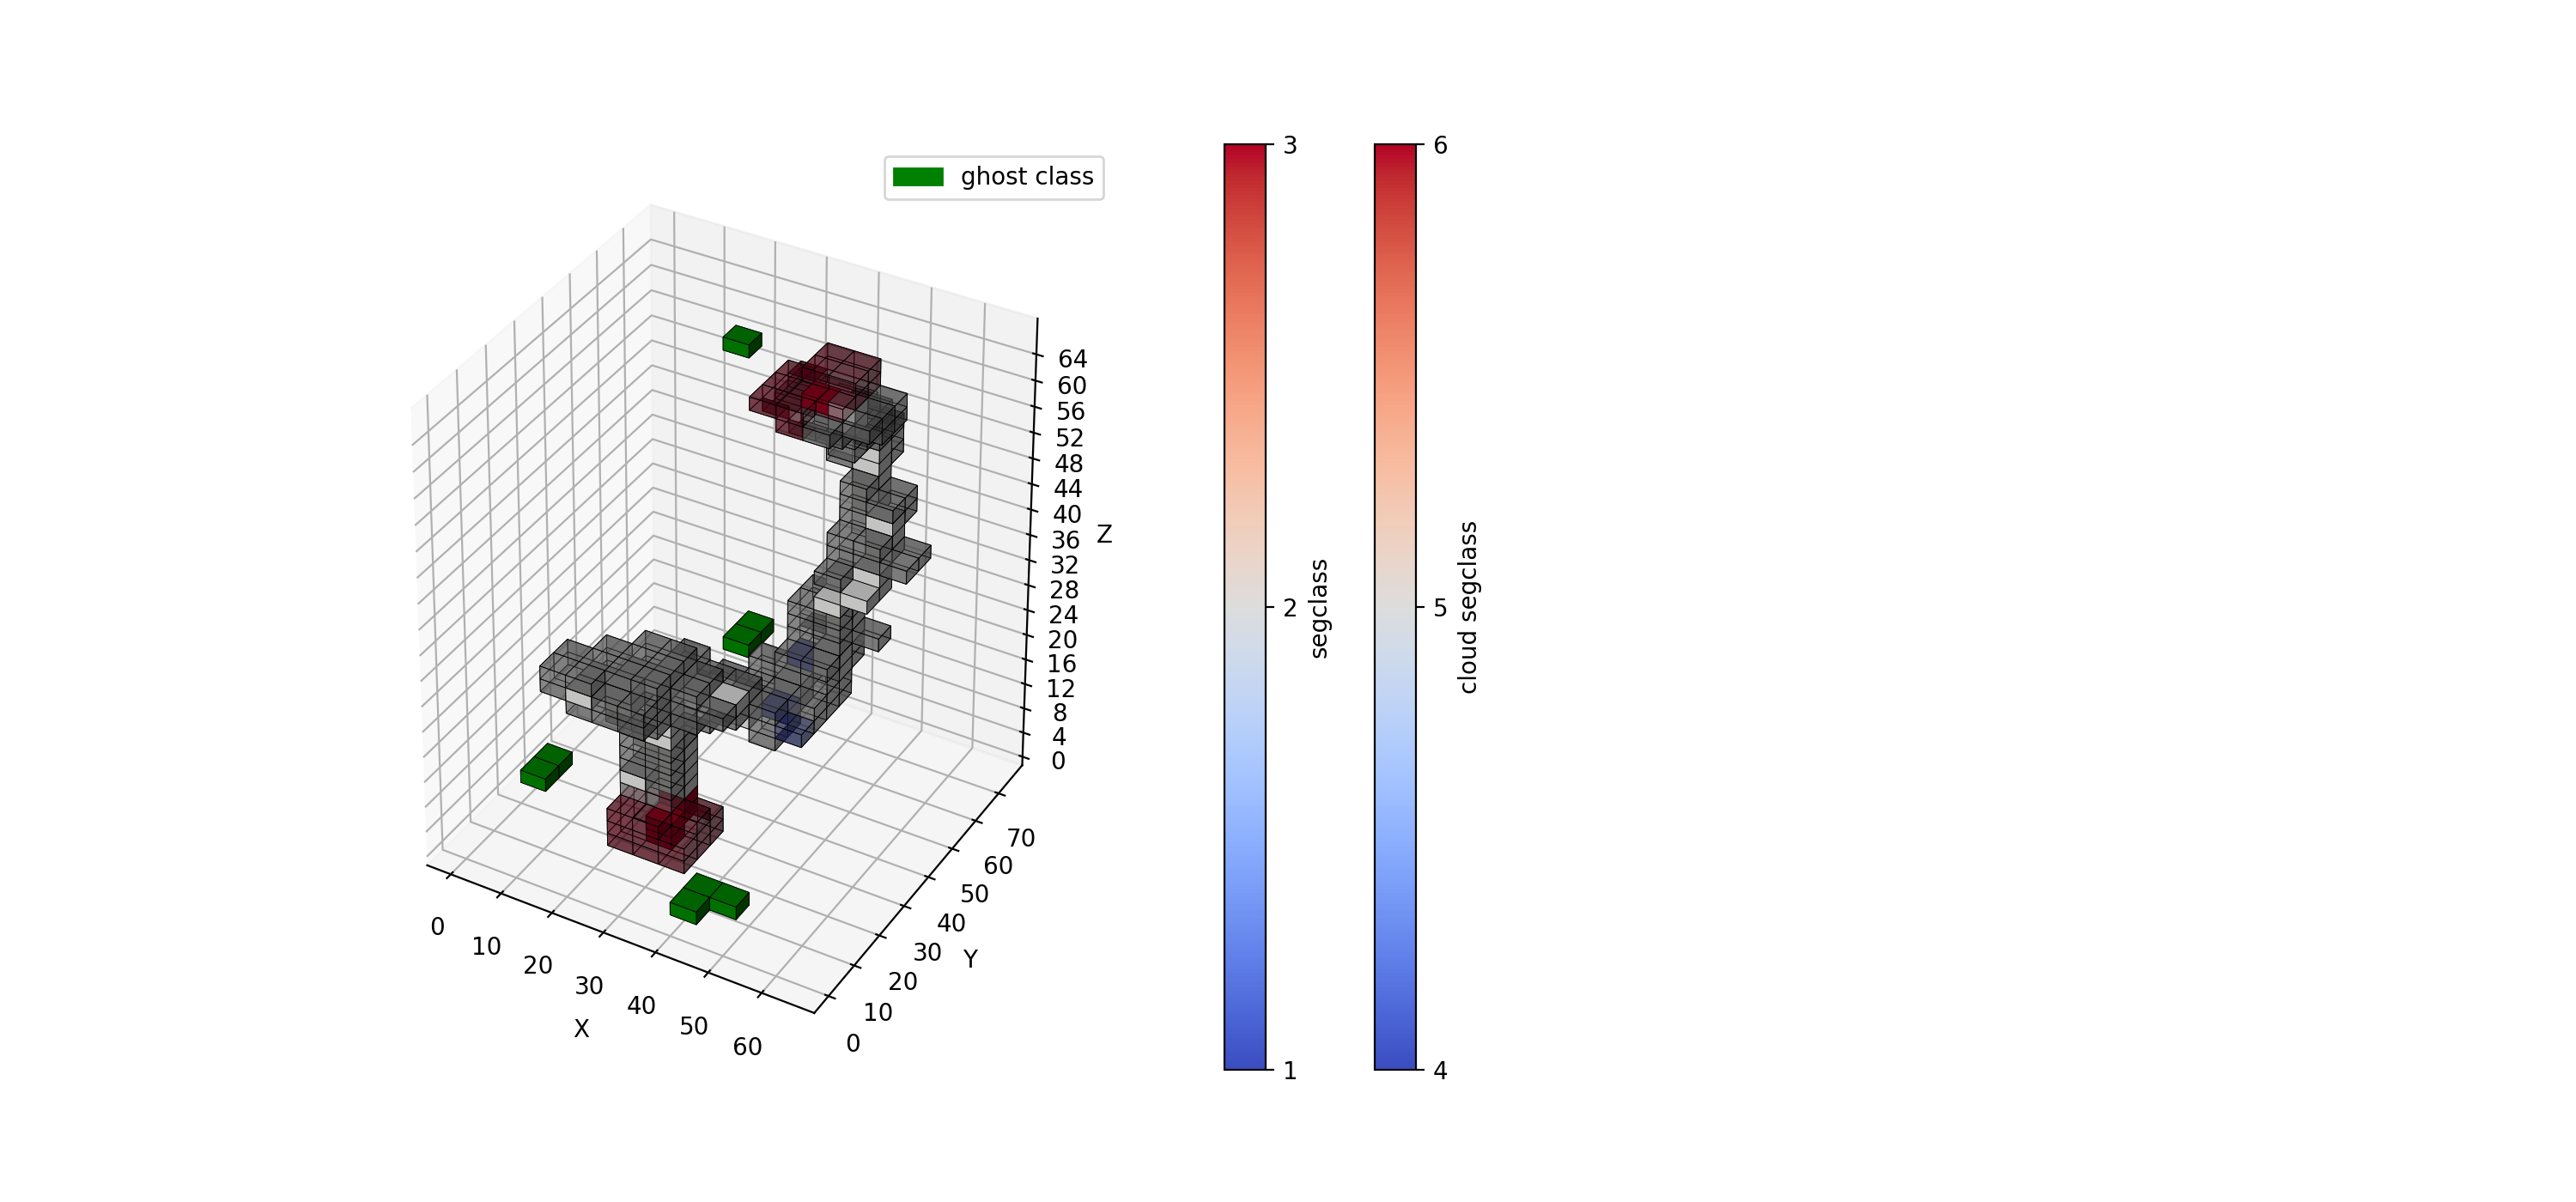

<IPython.core.display.Javascript object>


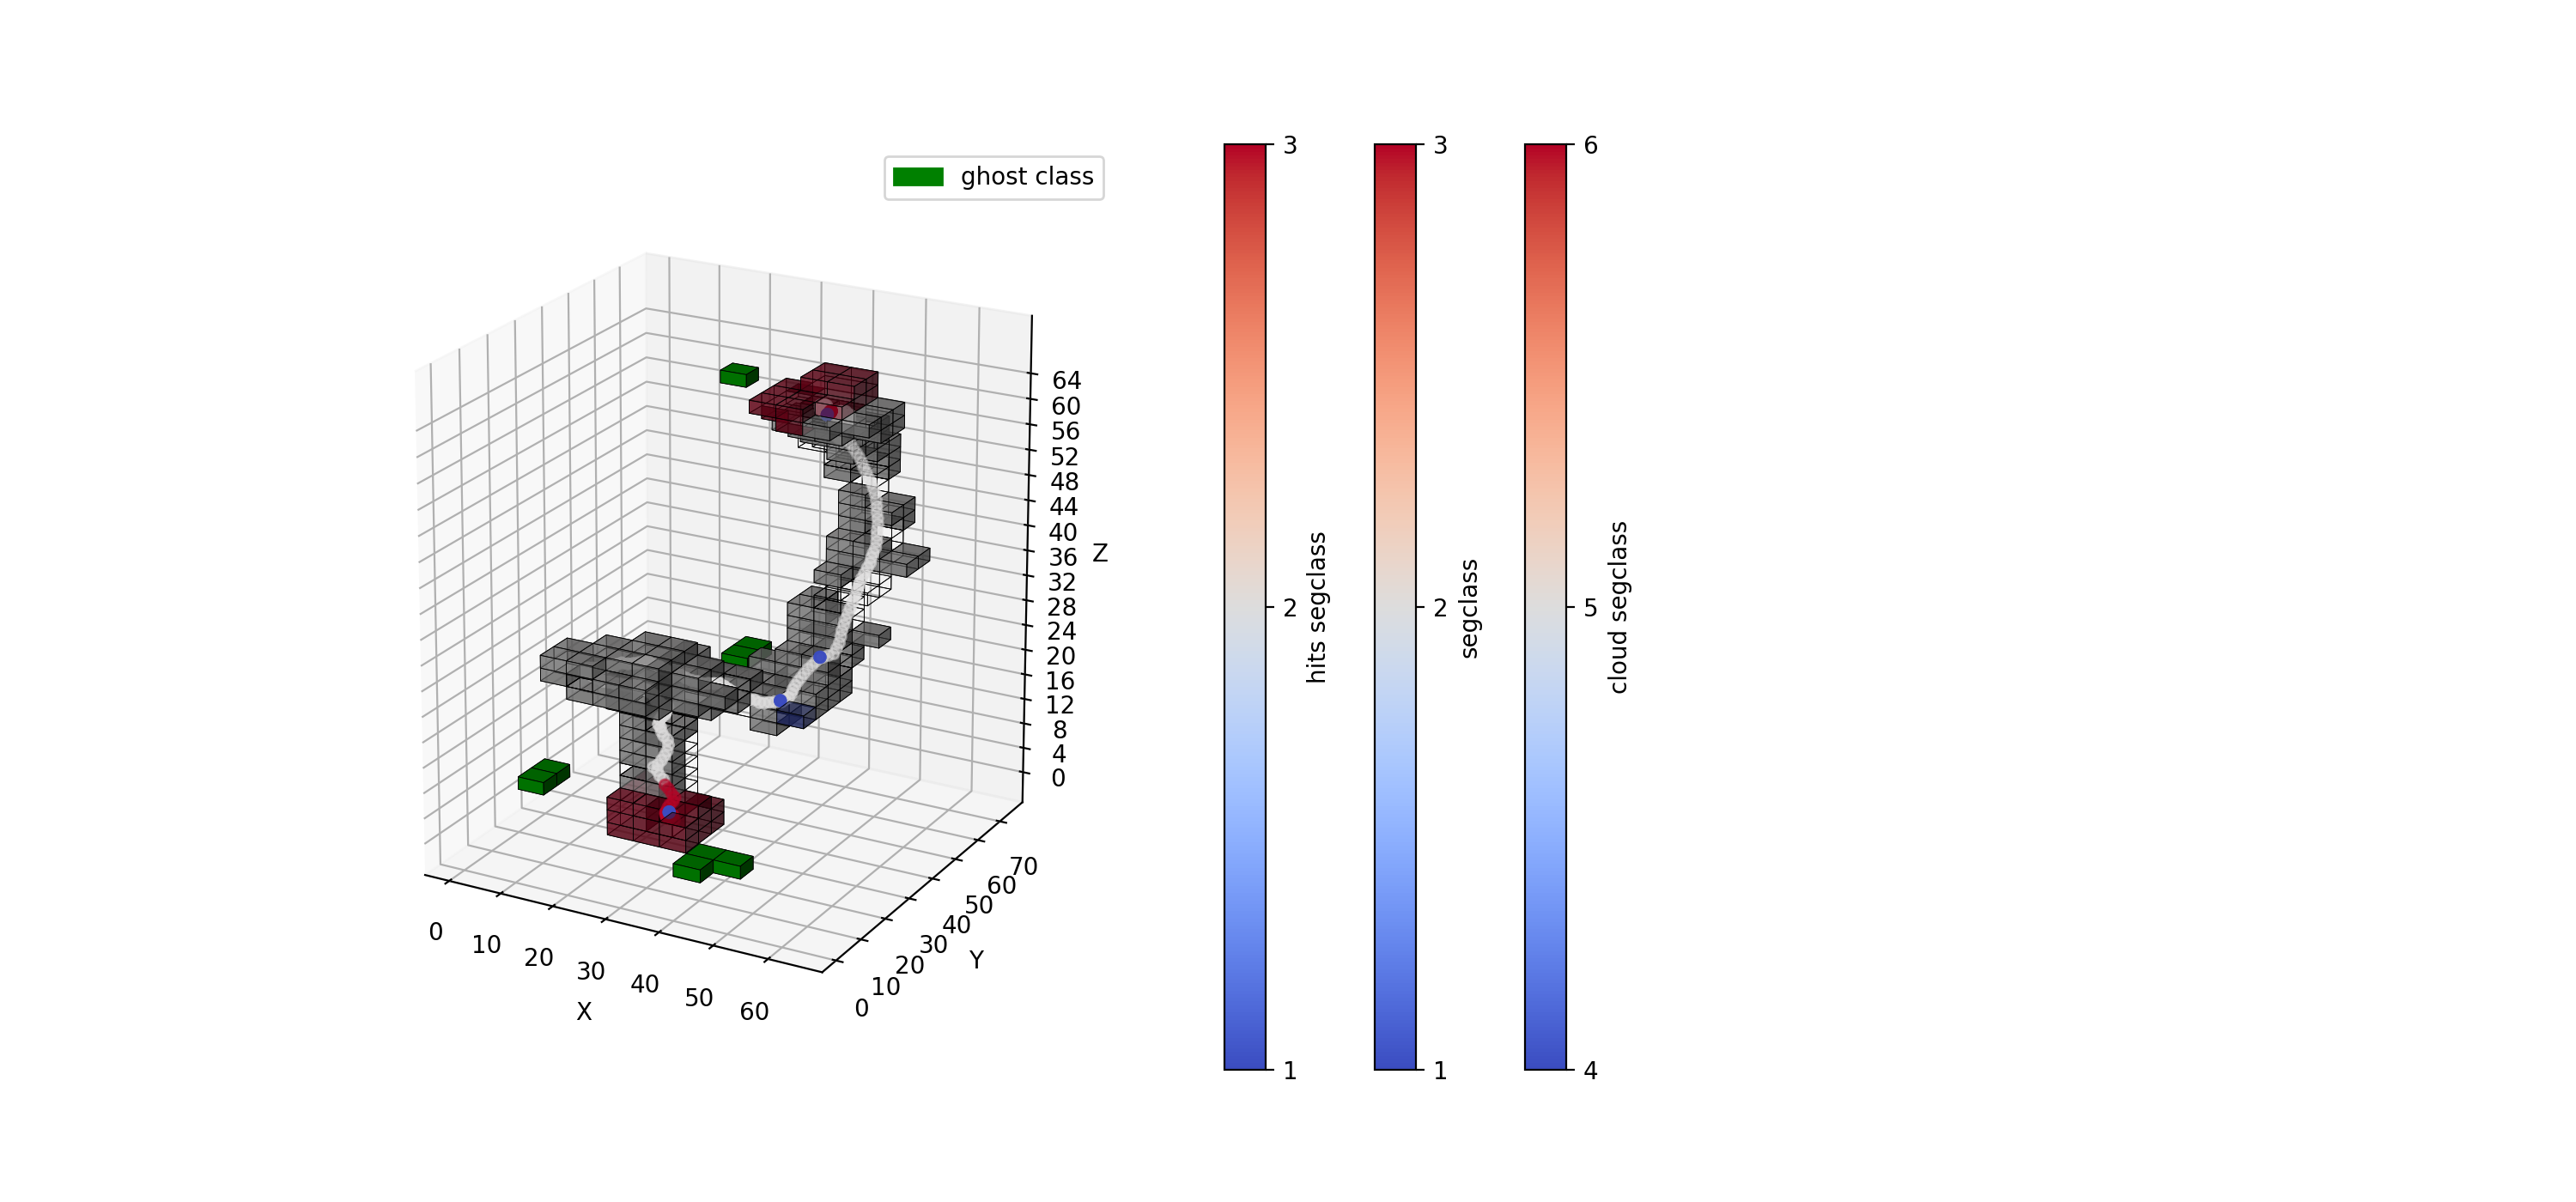

<IPython.core.display.Javascript object>


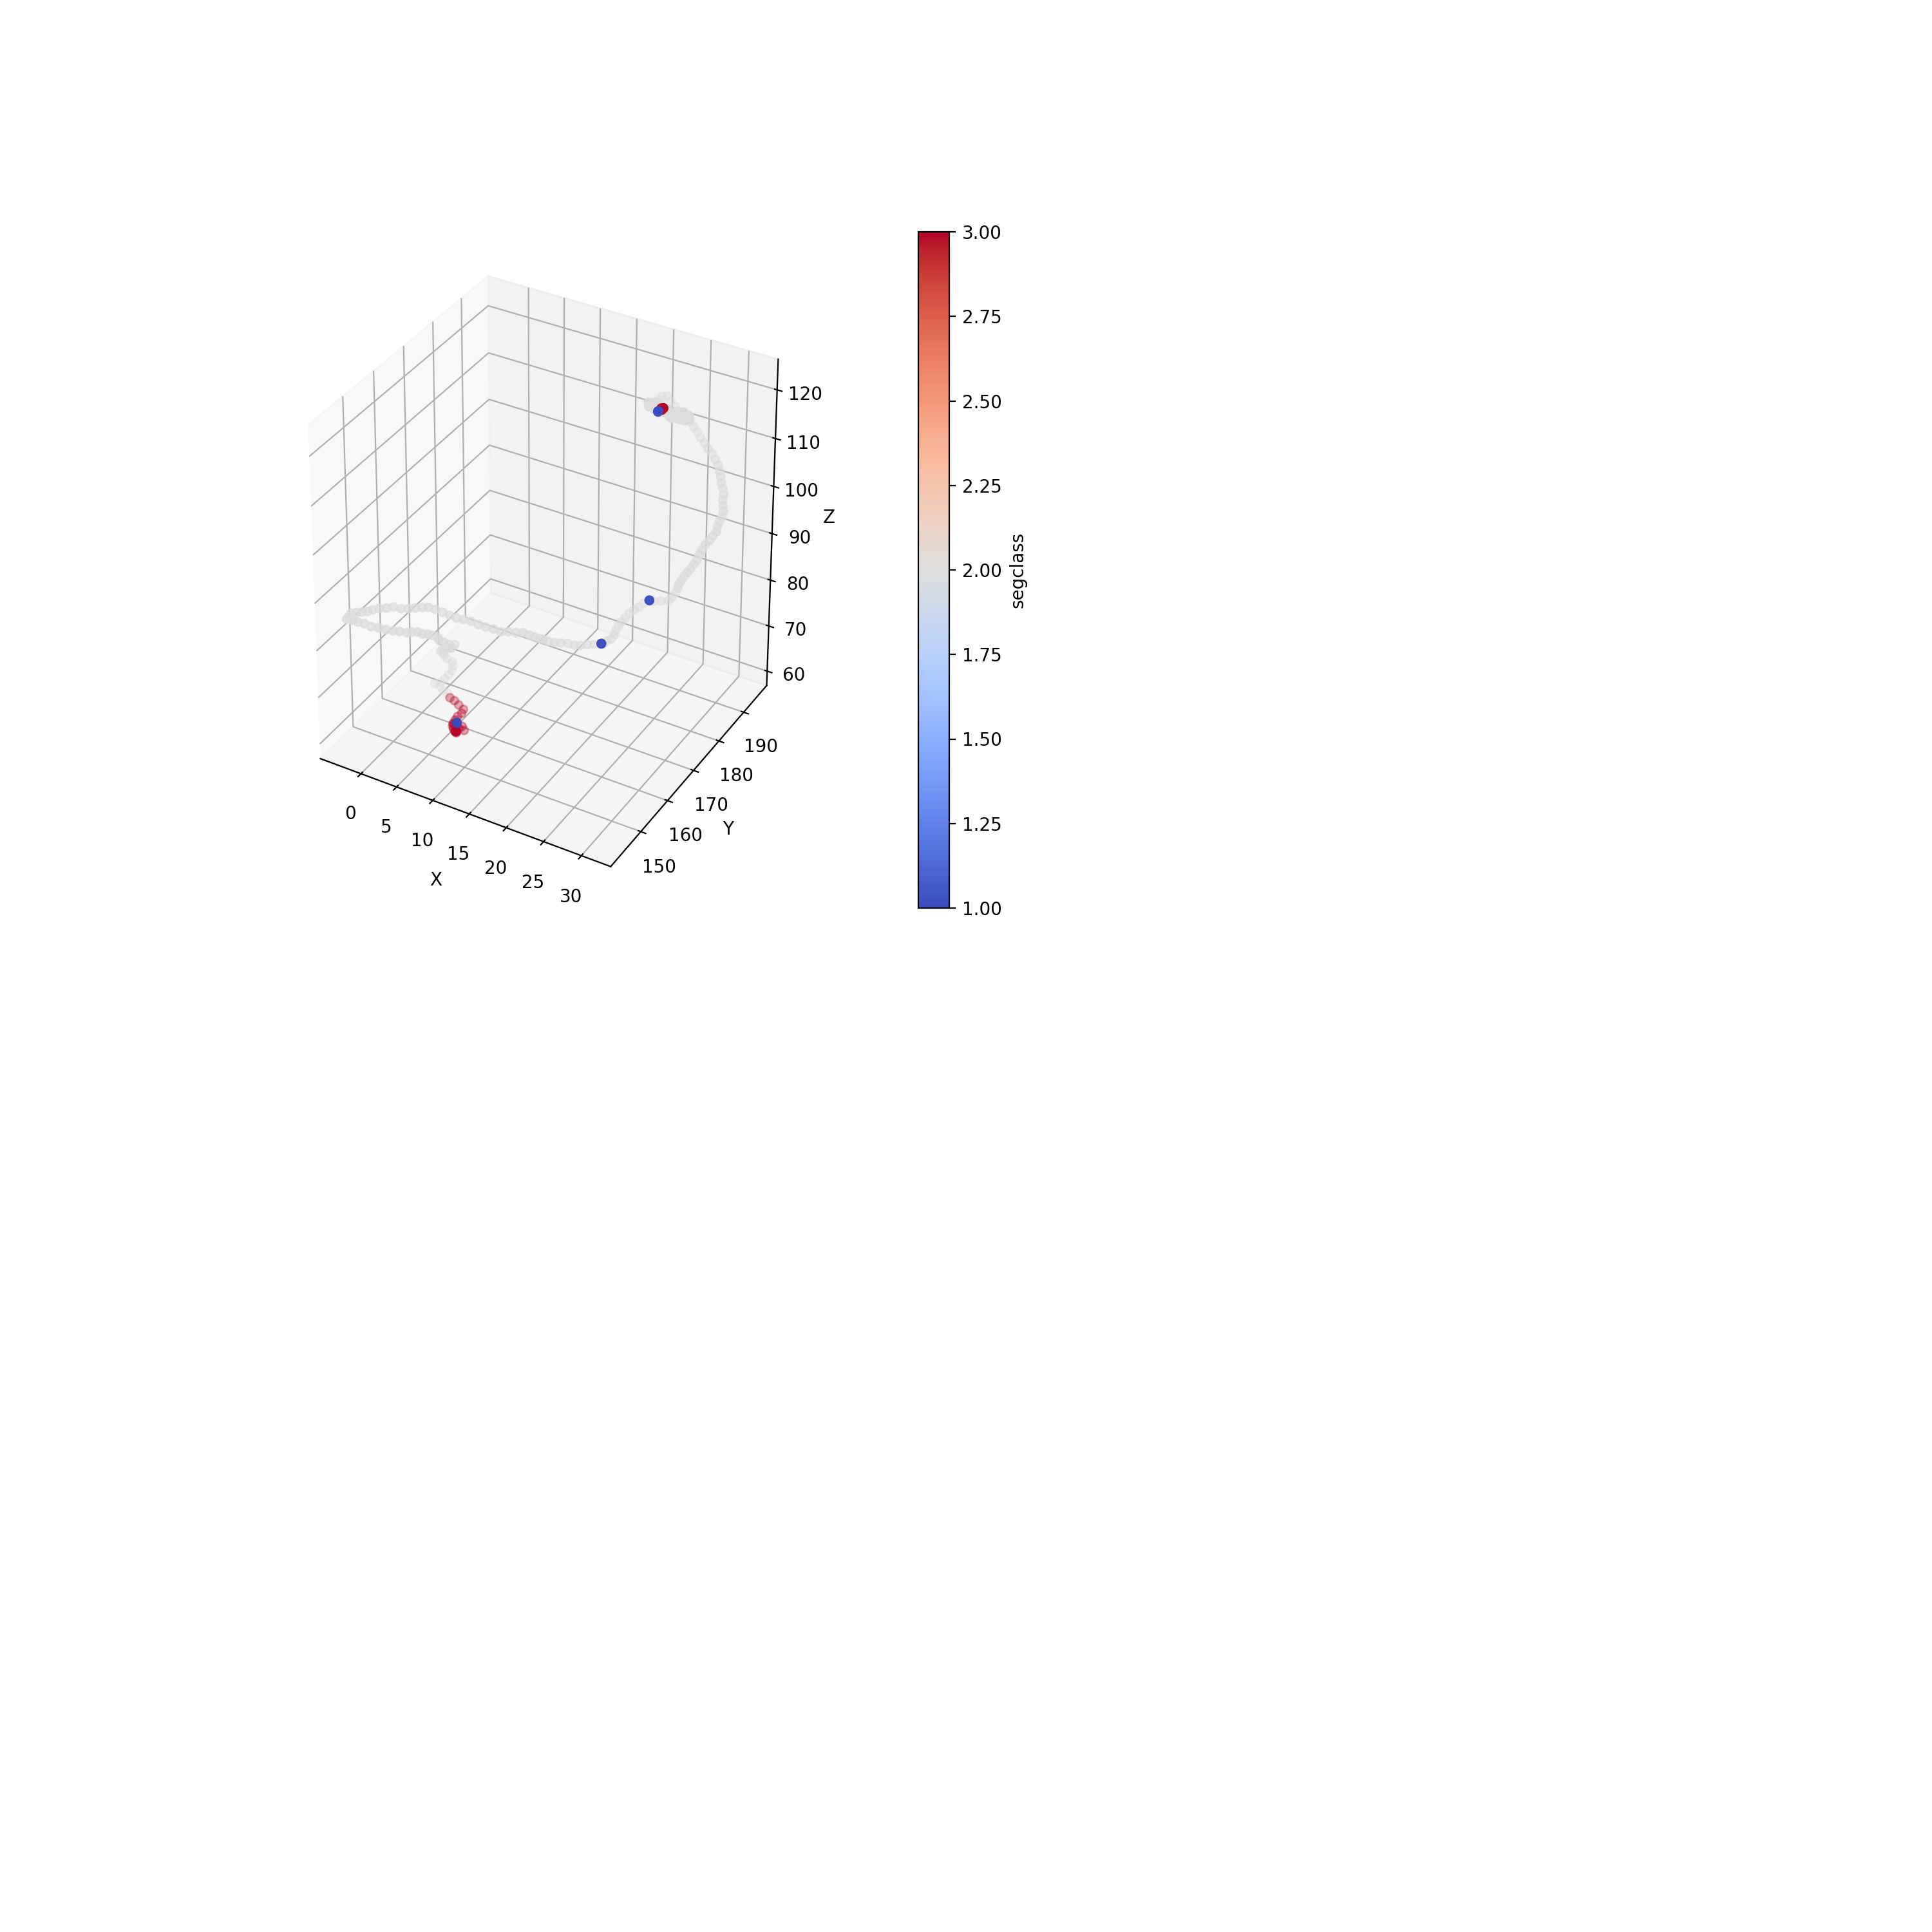

In [11]:
%matplotlib notebook

plot_cloud_voxels(event_beersh, voxel_size, opacity = [1, 0.5])
plot_cloud_voxels_and_hits(event_beersh, event_hits, voxel_size, opacity = [0, 0.6])
plot_3d_hits(event_hits, value = 'segclass', cmap = mpl.cm.coolwarm)

Añadí clase fantasma, cambié la voxelización (a 2mm en z), mejoré los plots. Lo siguiente: empezar la producción :)

# REVISIÓN FUNCIONES (FIDUCIAL CUT AND NEW VOXEL METHOD) 


In [5]:
from invisible_cities.core  .configure import configure
from invisible_cities.cities.components import index_tables
from next_sparseconvnet.data_io_scripts import MC_dataset_table_utils as mcutils
from utils.labelling_utils import add_hits_labels_MC

import sys
from glob import glob
import os

Primero voy a revisar lo del fiducial cut y el voxelizado rápido que hace marija porque me parece útil. Ver veo que funciona pero necesitaré obtener también el ratio con ese método, que seguro que hay una forma rápida...

In [6]:
mchits = dio.load_dst(directory, 'MC', 'hits')
mcpart = dio.load_dst(directory, 'MC', 'particles')

In [7]:
mchits = mchits[mchits.label == 'ACTIVE']

In [118]:
labelled_hits = add_hits_labels_MC(mchits, mcpart, blob_ener_loss_th = 0.25)

A partir de aqui, Marija con estos hits y con los bins (que ella hace más directa q yo con el bin_creator porque no pasa por tener un container_creator, como tengo ejemplificado en la siguiente casilla con un simple np.arange) pos hace el boundary cut (q es simplemente que los hits estén dentro de los bines... otra cosa es la escogición de dichos bines), el fiducial cut (preguntar si hay un valor fijo para NEW o algo...) y el voxelizado super rapido...

In [9]:
(np.arange(start_bin[2], start_bin[2]+total_size[2] + voxel_size[2], voxel_size[2])  == detector_bins[2]).all()

True

Es True, es decir el método marija y el mío para crear los bines coinciden :)

Bueno, voy a ver un poco lo que hizo :)

In [36]:
Rmax = 198

In [37]:
segclass = 'segclass'
binclass = 'binclass'
fiducial_cut = (labelled_hits.x**2+labelled_hits.y**2)<Rmax**2
binsX, binsY, binsZ = detector_bins
boundary_cut = (labelled_hits.x>=binsX.min()) & (labelled_hits.x<=binsX.max())\
                 & (labelled_hits.y>=binsY.min()) & (labelled_hits.y<=binsY.max())\
                 & (labelled_hits.z>=binsZ.min()) & (labelled_hits.z<=binsZ.max())

In [40]:
sum(fiducial_cut)/len(fiducial_cut)

143266

El fiducial cut elimina muy pocos hits de MC... pero de beersheba quizás son más, no sé si tendré que aplicar el corte en esos!!

Y obviamente el boundary cut tal y como lo tengo yo q es a todo el tamaño del detector pos entra todo... quizás no debería ser a todo el tamaño entonces los bines primero con el boundary cut me quitarían los hits de fuera y luego voxelizan con ese tamaño, por lo que no habría tampoco hits fuera nunca :)

In [13]:
sum(boundary_cut)/len(boundary_cut)

1.0

In [14]:
hits_act = labelled_hits[fiducial_cut & boundary_cut].reset_index(drop = True)

In [15]:
xbin = pd.cut(hits_act.x, binsX, labels = np.arange(0, len(binsX)-1)).astype(int)
ybin = pd.cut(hits_act.y, binsY, labels = np.arange(0, len(binsY)-1)).astype(int)
zbin = pd.cut(hits_act.z, binsZ, labels = np.arange(0, len(binsZ)-1)).astype(int)

In [16]:
hits_act.x

0         26.949236
1         26.678534
2         26.359673
3         25.943626
4         25.443466
            ...    
143232    36.669090
143233    25.682772
143234    25.682297
143235    26.329964
143236    26.328190
Name: x, Length: 143237, dtype: float32

In [17]:
binsX

array([-220., -215., -210., -205., -200., -195., -190., -185., -180.,
       -175., -170., -165., -160., -155., -150., -145., -140., -135.,
       -130., -125., -120., -115., -110., -105., -100.,  -95.,  -90.,
        -85.,  -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.,  -45.,
        -40.,  -35.,  -30.,  -25.,  -20.,  -15.,  -10.,   -5.,    0.,
          5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,   45.,
         50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,   90.,
         95.,  100.,  105.,  110.,  115.,  120.,  125.,  130.,  135.,
        140.,  145.,  150.,  155.,  160.,  165.,  170.,  175.,  180.,
        185.,  190.,  195.,  200.,  205.,  210.,  215.,  220.])

In [18]:
xbin

0         49
1         49
2         49
3         49
4         49
          ..
143232    51
143233    49
143234    49
143235    49
143236    49
Name: x, Length: 143237, dtype: int64

Pfff es un binado super smooth si me preguntan...

In [19]:
hits_act = hits_act.assign(xbin=xbin, ybin=ybin, zbin=zbin)
hits_act.event_id = hits_act.event_id.astype(np.int64)

In [20]:
from sklearn.utils.extmath import weighted_mode

In [50]:
out = hits_act.groupby(['xbin', 'ybin', 'zbin', 'event_id']).apply(
        lambda df:pd.Series({'energy':df['energy'].sum(),
                             segclass:int(weighted_mode(df[segclass], df['energy'])[0][0]),
                             binclass:int(df[binclass].unique()[0])})).reset_index()

hmmm tampoco es como súper inmediato eh... en plan hmmm...

Voy a comparar a ver q pasa, teniendo en cuenta q con mi método ya tengo implementado lo del ratio y no tendría que pensar mucho (aunque el método de marija es mil veces más elegante, en una línea)

In [21]:
from next_sparseconvnet.data_io_scripts.dataset_labeling_utils import get_bin_indices

In [22]:
from time import time

In [41]:
start = time()

mchits = dio.load_dst(directory, 'MC', 'hits')
mcpart = dio.load_dst(directory, 'MC', 'particles')
mchits = mchits[mchits.label == 'ACTIVE']

labelled_hits_prueba1 = add_hits_labels_MC(mchits, mcpart, blob_ener_loss_th = 0.25)

labelled_MC_vox_prueba1 = get_bin_indices(labelled_hits_prueba1, detector_bins, Rmax = 198000)
print(time() - start)

18.564238786697388


In [24]:
start = time()
labelled_MC_voxels, labelled_MC_hits = labelling_MC(directory, 
                                                            total_size, 
                                                            voxel_size, 
                                                            start_bin, 
                                                            blob_ener_loss_th = 0.25)
print(time() - start)

53.44498038291931


La diferencia de tiempo son unos 35 seg por archivo... que como se hace en paralelo pos tampoco no nos va a influir mucho... Es cierto que marija lo tiene más elegante pq lo hace en dos líneas, pero yo además tengo el ratio calculado, lo cual es un puntazo. Si veo rápidamente cómo sacar lo del ratio pruebo a hacerlo si no pepas

Parece q sí es sencillo porque parece que es su segundo argumento de salida!!! Mirar luego bien esto :)

In [46]:
labelled_MC_voxels

,event_id,x,y,z,ener,ratio,segclass,binclass
0,48000024,-1,33,144,0.029452,1.0,1,0
1,48000024,3,32,139,0.004629,1.0,1,0
2,48000024,3,32,140,0.022082,1.0,1,0
3,48000024,3,33,141,0.010240,1.0,1,0
4,48000024,3,33,142,0.017888,1.0,1,0
...,...,...,...,...,...,...,...,...
79,48000597,8,-6,150,0.004106,1.0,2,0
80,48000597,8,-5,150,0.028640,1.0,2,0
81,48000597,8,-4,149,0.011978,1.0,2,0
82,48000597,8,-4,150,0.008966,1.0,2,0


In [48]:
labelled_MC_vox_prueba1.sort_values(['event_id', 'xbin', 'ybin', 'zbin'])

,xbin,ybin,zbin,event_id,energy,segclass,binclass
20766,43,77,144,48000024,0.029452,1,0
25122,47,76,139,48000024,0.004629,1,0
25123,47,76,140,48000024,0.022082,1,0
25161,47,77,141,48000024,0.010240,1,0
25162,47,77,142,48000024,0.017888,1,0
...,...,...,...,...,...,...,...
29538,52,38,150,48000597,0.004106,2,0
29540,52,39,150,48000597,0.028640,2,0
29543,52,40,149,48000597,0.011978,2,0
29544,52,40,150,48000597,0.008966,2,0


In [35]:
detector_bins[0][43]/voxel_size[0] #coincide con el valor de x en el DF calulado por mis métodos asín que...

-1.0

Vale pintaba bonito pero es que el de marija tiene como voxeles las POSICIONES dentro del array de bines, q van de 0 a lo que sea. Yo lo hice con los voxeles escalados por así decirlo, así q van a ir del xbinminimo/voxel_size a xbinmax/voxelsize!! Que la transformación no es que suponga muchísimo pero paso la vd, mejor dejar las cosas como están!!

Algo q veo es q por un mísero voxel no coinciden en número... q está pasando :/ 

AH NADA supongo q cambiarán porque uno tiene cuts hechos y el otro no... cuando haga cuts en mi función pruebo a poner los mismos (aunque en este caso es solo el fiducial, el boundary hice q fuera igual.. así que si pongo rmax enorme sería como no tener fiducial tampoco)

Mmmmm siguen sin coincidir no se muy bien porque

Miraré esto bien cuando aplique yo mis cortes a lo mío, quizás es más relacionado con el boundary cut que en mi código me elimina los que están en el borde pero en el de Marija no o algo así, y coincide que justo hay 2 voxeles en el borde(???) no sé.

Bueno a lo que ibamos, saber si tengo q aplicarle corte fiducial (esto es añadir un par de líneas al código, puedo añadírselas sin saberlo de forma que si tiene valor furrule y si no pues no. Lo del boundary cut es más realmente escoger los límites del detector, pero puede que no valga con hacer un detector container más peque porque los voxeles que se quedan fuera a lo mejor hacen petar o dan algún tipo de fallo, valdría más eliminar antes los hits que no, entonces SÍ O SÍ añadiré la línea que antes de voxelizar me coge los bordes de los bins y elimina todo lo q hay fuera, no es na más ni supone una locura :)

Es decir, añadir boundary cut y la opción del fiducial, luego preguntar por ambos para saber q valores poner etc...

In [119]:
binsX, binsY, binsZ = detector_bins

In [120]:
boundary_cut = (labelled_hits.x>=binsX.min()) & (labelled_hits.x<=binsX.max())\
& (labelled_hits.y>=binsY.min()) & (labelled_hits.y<=binsY.max())\
& (labelled_hits.z>=binsZ.min()) & (labelled_hits.z<=binsZ.max())


In [121]:
Rmax = 207

In [122]:
if np.isnan(Rmax):
    fiducial_cut = pd.Series(np.ones(len(labelled_hits), dtype=bool)) #creates a mask with all trues
else: 
    fiducial_cut = (labelled_hits.x**2+labelled_hits.y**2)<Rmax**2

In [123]:
sum(fiducial_cut)

143266

In [126]:
labelled_hits[boundary_cut & fiducial_cut].reset_index(drop = True)

True

In [125]:
labelled_hits

,event_id,x,y,z,hit_id,energy,segclass,binclass,dist_hits,cumdist,particle_name,creator_proc
0,48000024,26.949236,181.372101,285.124054,0,0.005104,1.0,0,0.0,0.0,gamma,RadioactiveDecay
1,48000024,26.678534,180.700729,285.803558,0,0.003391,1.0,0,0.0,0.0,e-,phot
2,48000024,26.359673,180.022491,286.443512,1,0.004142,1.0,0,0.0,0.0,e-,phot
3,48000024,25.943626,179.287827,286.973358,2,0.006741,1.0,0,0.0,0.0,e-,phot
4,48000024,25.443466,178.509872,287.325806,3,0.004898,1.0,0,0.0,0.0,e-,phot
...,...,...,...,...,...,...,...,...,...,...,...,...
143261,48000597,36.669090,-49.727203,304.841309,9,0.013409,1.0,0,0.0,0.0,e-,eIoni
143262,48000597,25.682772,-62.683788,345.306335,0,0.000678,1.0,0,0.0,0.0,gamma,eBrem
143263,48000597,25.682297,-62.685036,345.305359,0,0.002433,1.0,0,0.0,0.0,e-,phot
143264,48000597,26.329964,-63.877815,345.103729,0,0.000989,1.0,0,0.0,0.0,gamma,phot


# PREVISIÓN DE PRODUCCIÓN (CONFIG FILES, PROGRAMA DE LANZAMIENTO...)

In [8]:
os.path.split(directory)

('/Users/mperez/NEXT/bersh_prod/prod_example',
 'Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_6206.root.h5')

Supongo que esto es porque puedo poner en el conf que la variable files_in sea una rollo blabla*.h5, entonces lo de glob y tal me hace una lista con todos los files_in para ir recorriendo i guess

In [52]:
glob(os.path.expandvars(files_in))

['/Users/mperez/NEXT/bersh_prod/prod_example/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_6206.root.h5']

In [41]:
sys.argv[0]

'/Users/mperez/Software/miniconda3/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py'